Разработку и тестирование маркет-мейкинговой стратегии лучше начать с проверки на исторических данных. Для этого в данной ячейке загружаются тиковые данные с Binance для валютных пар ETH/USDT и BTC/USDT, которые соответствуют условным токенам wETH и cbbtc. Использование данных с централизованной биржи (CEX) выбрано как наиболее простой и доступный способ получения точной рыночной информации. Эти данные будут использованы для дальнейшего моделирования и анализа поведения стратегии с учётом задержки исполнения.

In [1]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings("ignore")

binance = ccxt.binance()
binance.load_markets()

symbols = {
    'wETH': 'ETH/USDT',
    'cbbtc': 'BTC/USDT'
}

def fetch_recent_trades(symbol, minutes=10):
    since = int((datetime.utcnow() - timedelta(minutes=minutes)).timestamp() * 1000)
    all_trades = []
    while True:
        try:
            trades = binance.fetch_trades(symbol, since=since, limit=1000)
        except ccxt.NetworkError as e:
            print('Network error:', e)
            time.sleep(1)
            continue
        except ccxt.BaseError as e:
            print('Exchange error:', e)
            break

        if not trades:
            break

        for trade in trades:
            if trade['timestamp'] >= since:
                all_trades.append({
                    'timestamp': trade['timestamp'],
                    'datetime': trade['datetime'],
                    'symbol': symbol,
                    'price': trade['price'],
                    'amount': trade['amount'],
                    'side': trade['side']
                })

        last_timestamp = trades[-1]['timestamp']
        if last_timestamp <= since:
            break
        since = last_timestamp + 1
        time.sleep(0.3) 

    return pd.DataFrame(all_trades)

data = {}
for key, symbol in symbols.items():
    print(f'Загружаю трейды для {symbol}...')
    df = fetch_recent_trades(symbol)
    data[key] = df
    print(f'{len(df)} трейдов загружено для {symbol}')

data['wETH'].tail()

Загружаю трейды для ETH/USDT...
185558 трейдов загружено для ETH/USDT
Загружаю трейды для BTC/USDT...
98694 трейдов загружено для BTC/USDT


,timestamp,datetime,symbol,price,amount,side
185553,1746710724075,2025-05-08T13:25:24.075Z,ETH/USDT,1970.00,0.6930,buy
185554,1746710724076,2025-05-08T13:25:24.076Z,ETH/USDT,1970.00,0.7040,buy
185555,1746710724259,2025-05-08T13:25:24.259Z,ETH/USDT,1969.99,0.0325,sell
185556,1746710724260,2025-05-08T13:25:24.260Z,ETH/USDT,1969.99,1.1019,sell
185557,1746710724794,2025-05-08T13:25:24.794Z,ETH/USDT,1970.00,1.6698,buy


Выполним проверку на пропуски 

In [3]:
def check_data_quality(df, name='dataset'):
    print(f"\nПроверка для: {name}")
    
    print("Пропуски по колонкам:")
    print(df.isnull().sum())

    if 'price' in df.columns and 'amount' in df.columns:
        invalid_prices = (df['price'] <= 0).sum()
        invalid_amounts = (df['amount'] <= 0).sum()
        print(f" Некорректные цены (<= 0): {invalid_prices}")
        print(f" Некорректные объёмы (<= 0): {invalid_amounts}")

    print("Диапазон времени:")
    print(pd.to_datetime(df['timestamp'], unit='ms').min(), "->", pd.to_datetime(df['timestamp'], unit='ms').max())

check_data_quality(data['wETH'], 'wETH / ETHUSDT')
check_data_quality(data['cbbtc'], 'cbbtc / BTCUSDT')


Проверка для: wETH / ETHUSDT
Пропуски по колонкам:
timestamp    0
datetime     0
symbol       0
price        0
amount       0
side         0
dtype: int64
 Некорректные цены (<= 0): 0
 Некорректные объёмы (<= 0): 0
Диапазон времени:
2025-05-08 10:12:18.351000 -> 2025-05-08 13:25:24.794000

Проверка для: cbbtc / BTCUSDT
Пропуски по колонкам:
timestamp    0
datetime     0
symbol       0
price        0
amount       0
side         0
dtype: int64
 Некорректные цены (<= 0): 0
 Некорректные объёмы (<= 0): 0
Диапазон времени:
2025-05-08 10:15:24 -> 2025-05-08 13:26:48.190000


Для корректного сопоставления тиковых данных обеих валютных пар необходимо выровнять их временные диапазоны.

In [5]:
data['wETH']['datetime'] = pd.to_datetime(data['wETH']['timestamp'], unit='ms')
data['cbbtc']['datetime'] = pd.to_datetime(data['cbbtc']['timestamp'], unit='ms')

start = max(data['wETH']['datetime'].min(), data['cbbtc']['datetime'].min())
end = min(data['wETH']['datetime'].max(), data['cbbtc']['datetime'].max())

print(f"Общий диапазон: {start} — {end}")


Общий диапазон: 2025-05-08 10:15:24 — 2025-05-08 13:25:24.794000


In [7]:
def trim_by_time(df, start_time, end_time):
    return df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)].reset_index(drop=True)

data['wETH'] = trim_by_time(data['wETH'], start, end)
data['cbbtc'] = trim_by_time(data['cbbtc'], start, end)

print("После обрезки:")
print("wETH:", data['wETH']['datetime'].min(), "->", data['wETH']['datetime'].max())
print("cbbtc:", data['cbbtc']['datetime'].min(), "->", data['cbbtc']['datetime'].max())

После обрезки:
wETH: 2025-05-08 10:15:24.151000 -> 2025-05-08 13:25:24.794000
cbbtc: 2025-05-08 10:15:24 -> 2025-05-08 13:25:24.482000


Отобразим данные в виде графиков

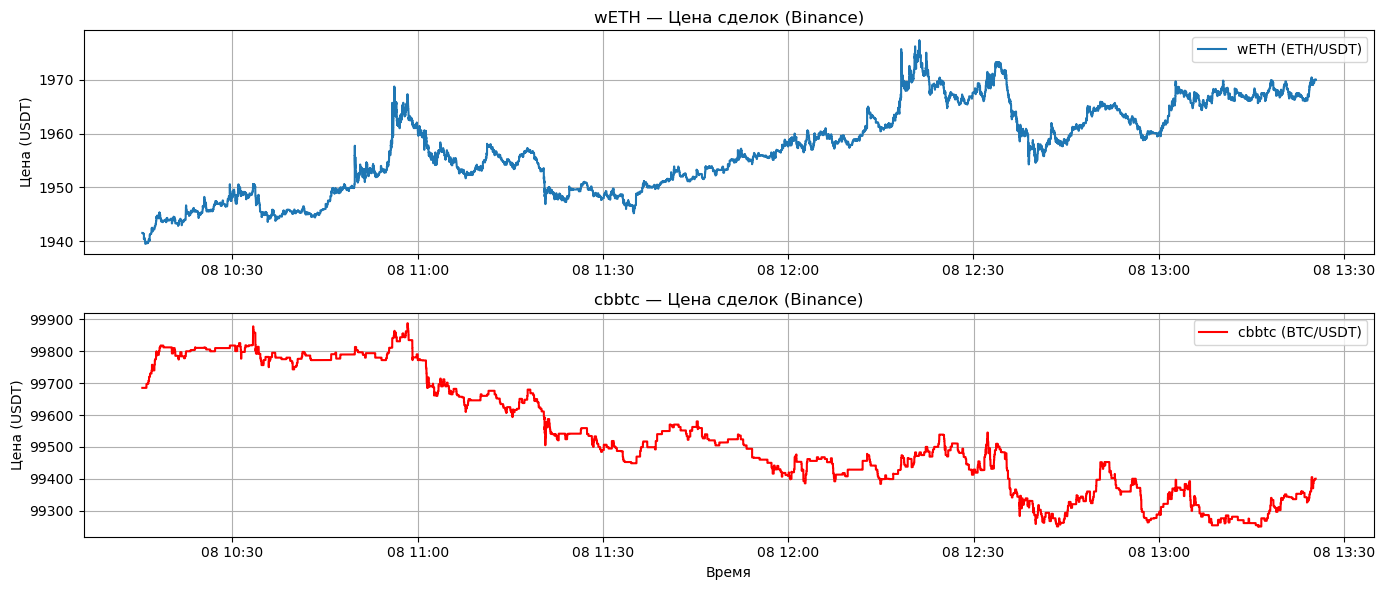

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(data['wETH']['datetime'], data['wETH']['price'], label='wETH (ETH/USDT)')
plt.title('wETH — Цена сделок (Binance)')
plt.ylabel('Цена (USDT)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['cbbtc']['datetime'], data['cbbtc']['price'], label='cbbtc (BTC/USDT)', color='red')
plt.title('cbbtc — Цена сделок (Binance)')
plt.xlabel('Время')
plt.ylabel('Цена (USDT)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Сохраним данные в CSV файлы для дальнейшей работы

In [11]:
data['wETH'].to_csv('weth_trades_clean.csv', index=False)
data['cbbtc'].to_csv('cbbtc_trades_clean.csv', index=False)

del data

weth_df = pd.read_csv('weth_trades_clean.csv', parse_dates=['datetime'])
cbbtc_df = pd.read_csv('cbbtc_trades_clean.csv', parse_dates=['datetime'])

print(weth_df.head(2))
print(cbbtc_df.head(2))

       timestamp                datetime    symbol    price  amount side
0  1746699324151 2025-05-08 10:15:24.151  ETH/USDT  1941.56  0.0214  buy
1  1746699324338 2025-05-08 10:15:24.338  ETH/USDT  1941.56  0.0257  buy
       timestamp                datetime    symbol     price   amount  side
0  1746699324000 2025-05-08 10:15:24.000  BTC/USDT  99685.17  0.00048   buy
1  1746699324165 2025-05-08 10:15:24.165  BTC/USDT  99685.16  0.00010  sell


Проводим тестирование классической модели Avellaneda-Stoikov без участия RL-агентов. Для выбранных валютных пар wETH и cbbtc рассчитываются котировки bid/ask с учётом текущей цены, волатильности и задержки исполнения (latency). Модель симулирует исполнение ордеров через фиксированное количество секунд после подачи. Учитываются ограничения по объёму позиции (inventory_limit), а также накапливается PnL (прибыль/убыток). Результаты — динамика цены, позиции и PnL — визуализируются на графиках

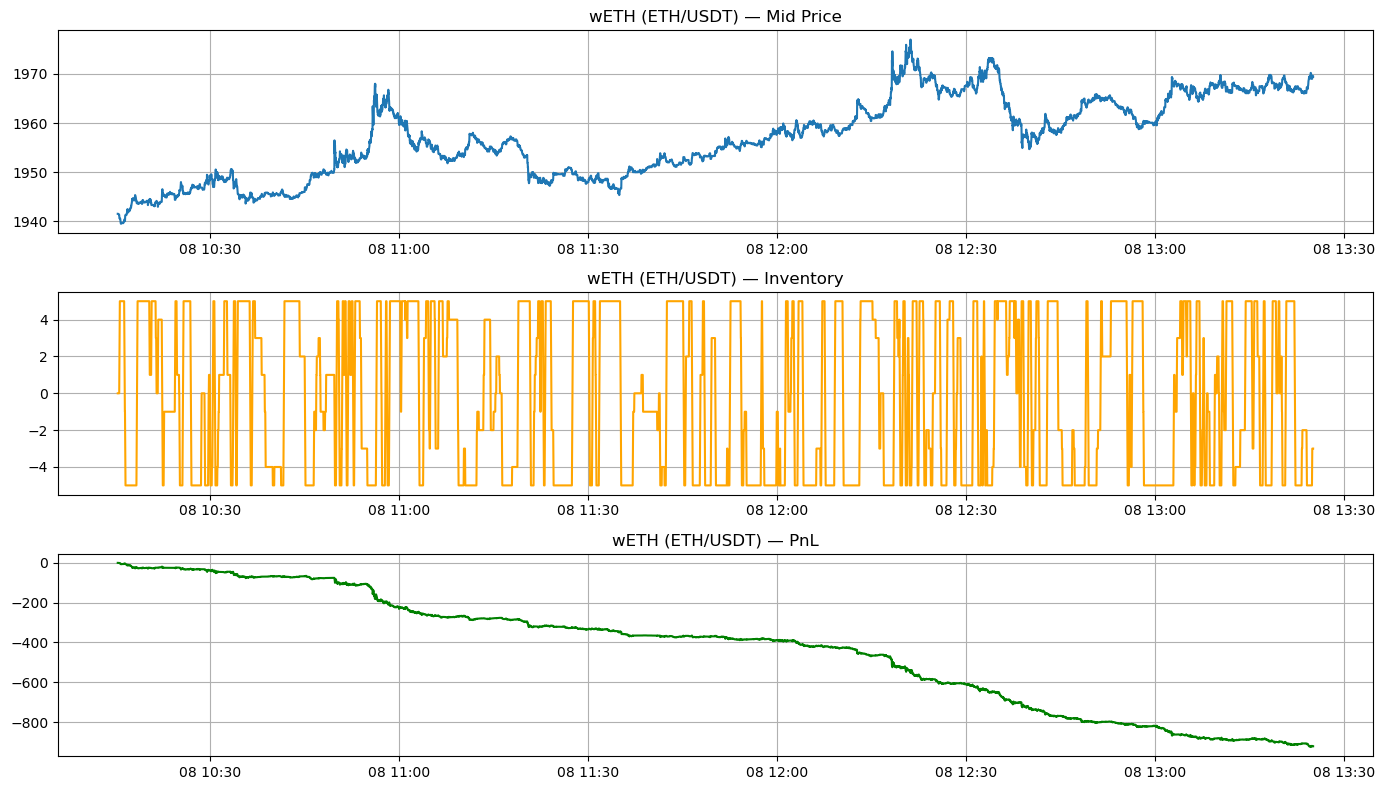

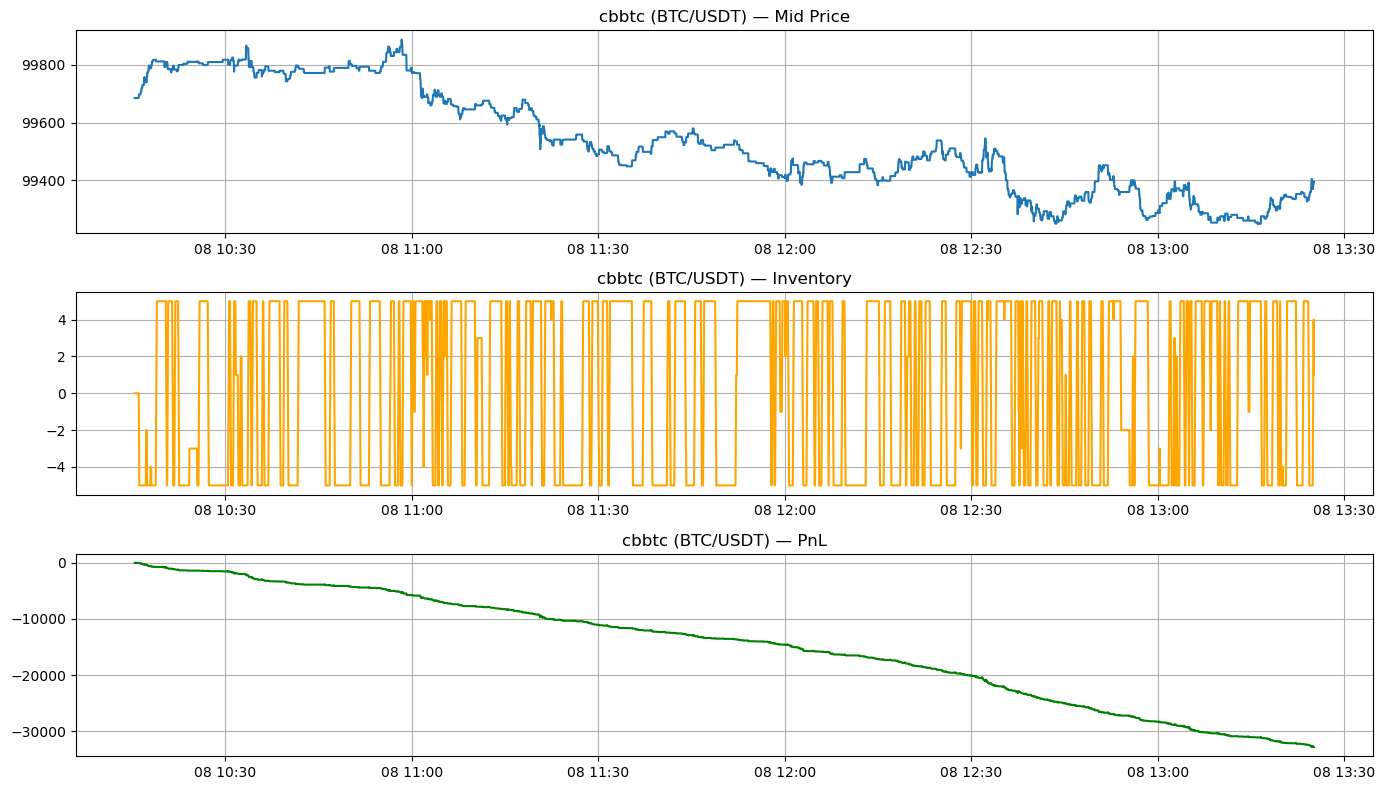

In [13]:
import numpy as np

gamma = 0.1
k = 1.5
latency = 15
inventory_limit = 5

def run_avellaneda_backtest(df, label=''):
    df = df.copy()
    df.set_index('datetime', inplace=True)
    price_series = df['price'].resample('1S').last().ffill()

    log_ret = np.log(price_series / price_series.shift(1))
    volatility = log_ret.rolling(window=30).std().fillna(method='bfill')

    inventory = 0
    cash = 0
    records = []
    active_orders = []
    T = len(price_series)

    for t in range(T - latency - 1):
        time_now = price_series.index[t]
        S = price_series.iloc[t]
        sigma = volatility.iloc[t]

        r = S + inventory * gamma * sigma**2 * (T - t)
        delta = gamma * sigma**2 * (T - t) + (2 / gamma) * np.log(1 + gamma / k)
        bid = r - delta / 2
        ask = r + delta / 2

        active_orders.append({
            'submit_time': t,
            'expire_time': t + latency,
            'bid': bid,
            'ask': ask
        })

        for order in list(active_orders):
            if order['expire_time'] == t:
                exec_price = price_series.iloc[t]

                if exec_price <= order['bid'] and inventory < inventory_limit:
                    inventory += 1
                    cash -= order['bid']
                elif exec_price >= order['ask'] and inventory > -inventory_limit:
                    inventory -= 1
                    cash += order['ask']

                active_orders.remove(order)

        pnl = cash + inventory * S
        records.append({
            'time': time_now,
            'mid_price': S,
            'inventory': inventory,
            'cash': cash,
            'pnl': pnl
        })

    return pd.DataFrame(records).set_index('time')


weth_result = run_avellaneda_backtest(weth_df, label='wETH')
cbbtc_result = run_avellaneda_backtest(cbbtc_df, label='cbbtc')

def plot_results(result_df, title_prefix):
    plt.figure(figsize=(14, 8))

    plt.subplot(3, 1, 1)
    plt.plot(result_df.index, result_df['mid_price'], label='Mid Price')
    plt.title(f'{title_prefix} — Mid Price')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(result_df.index, result_df['inventory'], label='Inventory', color='orange')
    plt.title(f'{title_prefix} — Inventory')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(result_df.index, result_df['pnl'], label='PnL', color='green')
    plt.title(f'{title_prefix} — PnL')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(weth_result, 'wETH (ETH/USDT)')
plot_results(cbbtc_result, 'cbbtc (BTC/USDT)')

In [29]:
del weth_df
del cbbtc_df

Делаем чистку датасета и загружаем данные из CSV для продолжения исследований.

In [31]:
weth_df = pd.read_csv('weth_trades_clean.csv', parse_dates=['datetime'])
cbbtc_df = pd.read_csv('cbbtc_trades_clean.csv', parse_dates=['datetime'])

weth_df.set_index('datetime', inplace=True)
cbbtc_df.set_index('datetime', inplace=True)

weth_prices = weth_df['price'].resample('1S').last().ffill().values[:1000]
cbbtc_prices = cbbtc_df['price'].resample('1S').last().ffill().values[:1000]

Для начала тестирования стратегии с использованием RL реализована среда MarketMakingEnvLatency, учитывающая задержку исполнения ордера (latency). В качестве агентов используются готовые алгоритмы PPO и A2C. Каждый агент обучается на ценовых данных токенов wETH и cbbtc и совершает действия: купить, продать или ждать. После обучения отображаются точки входа и выхода, а также рассчитывается суммарный PnL, количество прибыльных и убыточных сделок. Это позволяет на базовом уровне сравнить поведение агентов и оценить их потенциал.

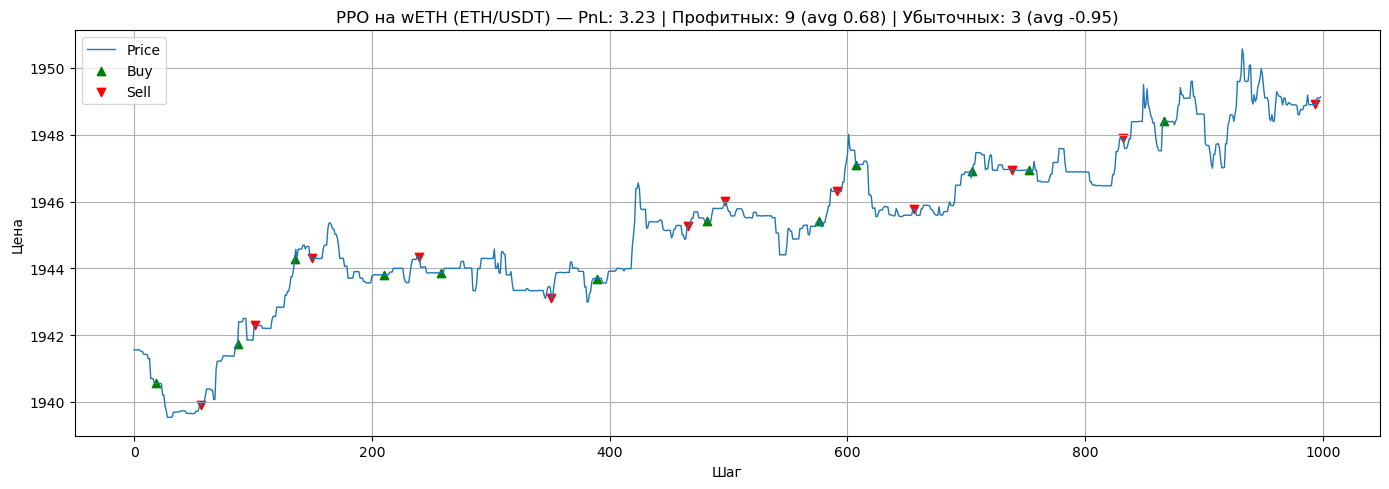

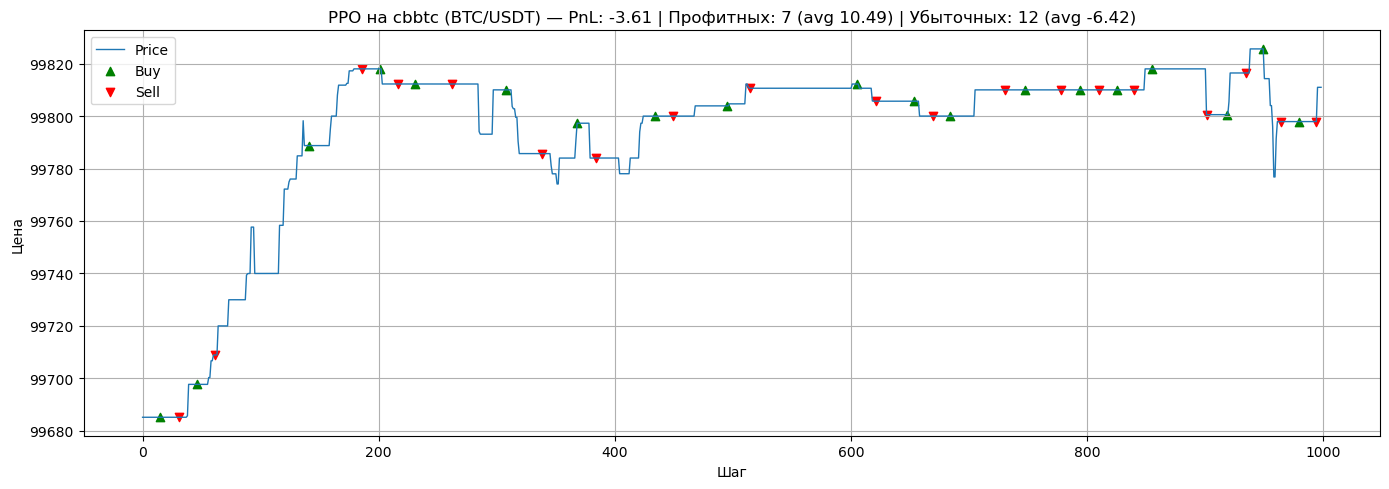

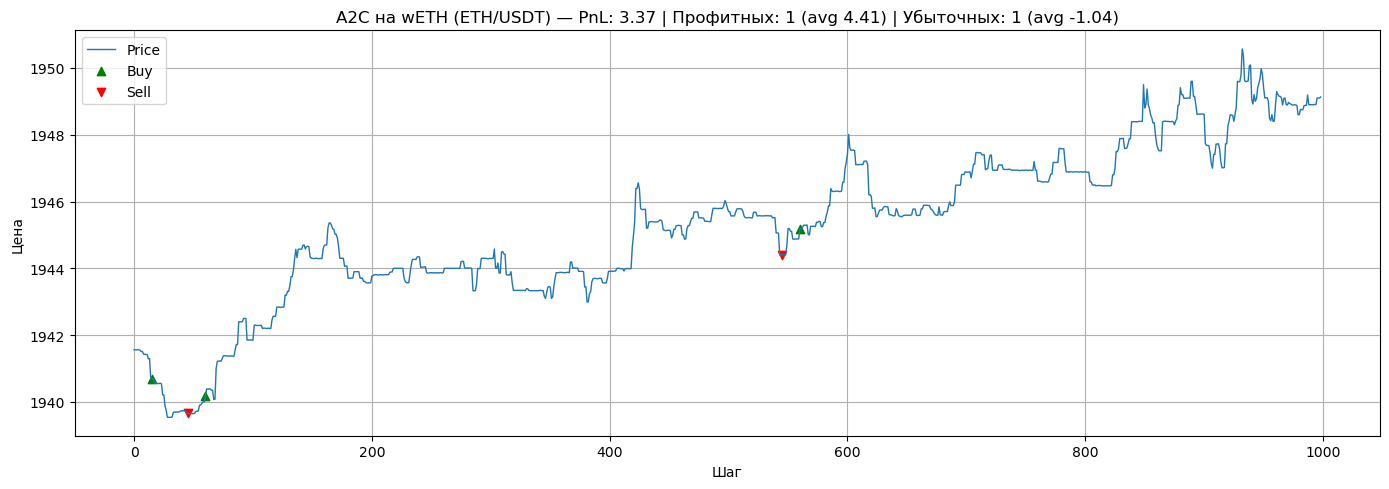

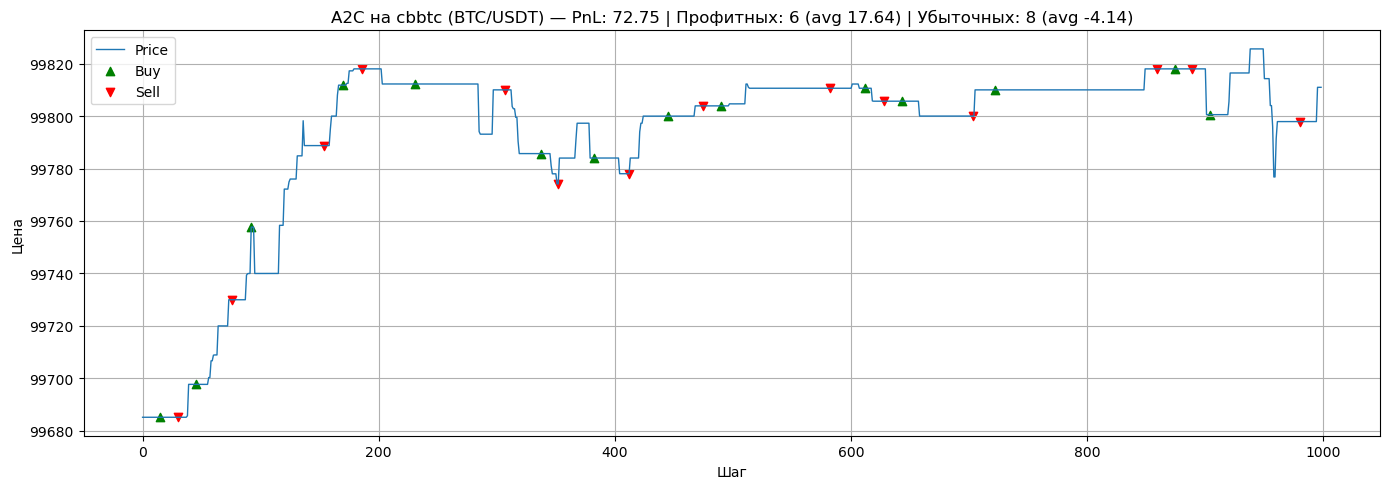

In [33]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, PPO

class MarketMakingEnvLatency(gym.Env):
    def __init__(self, prices, latency=15):
        super().__init__()
        self.prices = prices
        self.latency = latency
        self.index = 0
        self.inventory = 0
        self.entry_price = None
        self.pending_action = None
        self.pending_time = None
        self.trades = []

        self.observation_space = spaces.Box(low=0, high=100000, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        self.index = 0
        self.inventory = 0
        self.entry_price = 0
        self.pending_action = None
        self.pending_time = None
        self.trades = []
        return np.array([self.prices[self.index], self.inventory], dtype=np.float32), {}

    def step(self, action):
        price = self.prices[self.index]
        reward = 0

        if self.pending_action is not None and self.index >= self.pending_time:
            exec_price = self.prices[self.pending_time]
            if self.pending_action == 1 and self.inventory == 0:
                self.inventory = 1
                self.entry_price = exec_price
                self.trades.append(('buy', self.pending_time, exec_price))
            elif self.pending_action == 2 and self.inventory == 1:
                reward = exec_price - self.entry_price
                self.trades.append(('sell', self.pending_time, exec_price, reward))
                self.inventory = 0
                self.entry_price = 0
            self.pending_action = None
            self.pending_time = None

        if action in [1, 2] and self.pending_action is None:
            self.pending_action = action
            self.pending_time = self.index + self.latency

        self.index += 1
        done = self.index >= len(self.prices) - 1
        obs = np.array([self.prices[self.index], self.inventory], dtype=np.float32)
        return obs, reward, done, False, {}

def train_and_plot(Algo, prices, label):
    env = MarketMakingEnvLatency(prices, latency=15)
    model = Algo("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=5000)

    obs, _ = env.reset()
    prices_log = []
    actions = []
    pnl = 0

    for _ in range(len(prices) - 1):
        action, _ = model.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        prices_log.append(obs[0])
        actions.append(action)
        pnl += reward
        if done or truncated:
            break

    buy_idx = [t[1] for t in env.trades if t[0] == 'buy']
    sell_idx = [t[1] for t in env.trades if t[0] == 'sell']
    profit_trades = [t for t in env.trades if t[0] == 'sell' and t[3] > 0]
    loss_trades = [t for t in env.trades if t[0] == 'sell' and t[3] <= 0]
    profit_count = len(profit_trades)
    loss_count = len(loss_trades)
    profit_avg = np.mean([t[3] for t in profit_trades]) if profit_trades else 0
    loss_avg = np.mean([t[3] for t in loss_trades]) if loss_trades else 0

    plt.figure(figsize=(14, 5))
    plt.plot(prices_log, label="Price", linewidth=1)
    plt.scatter(buy_idx, [prices_log[i] for i in buy_idx], color='green', marker='^', label='Buy')
    plt.scatter(sell_idx, [prices_log[i] for i in sell_idx], color='red', marker='v', label='Sell')
    plt.title(
        f"{label} — PnL: {pnl:.2f} | Профитных: {profit_count} (avg {profit_avg:.2f}) | Убыточных: {loss_count} (avg {loss_avg:.2f})"
    )
    plt.xlabel("Шаг")
    plt.ylabel("Цена")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for algo_name, Algo in [("PPO", PPO), ("A2C", A2C)]:
    train_and_plot(Algo, weth_prices, f"{algo_name} на wETH (ETH/USDT)")
    train_and_plot(Algo, cbbtc_prices, f"{algo_name} на cbbtc (BTC/USDT)")


Аналогично тестируем алгоритм SAC

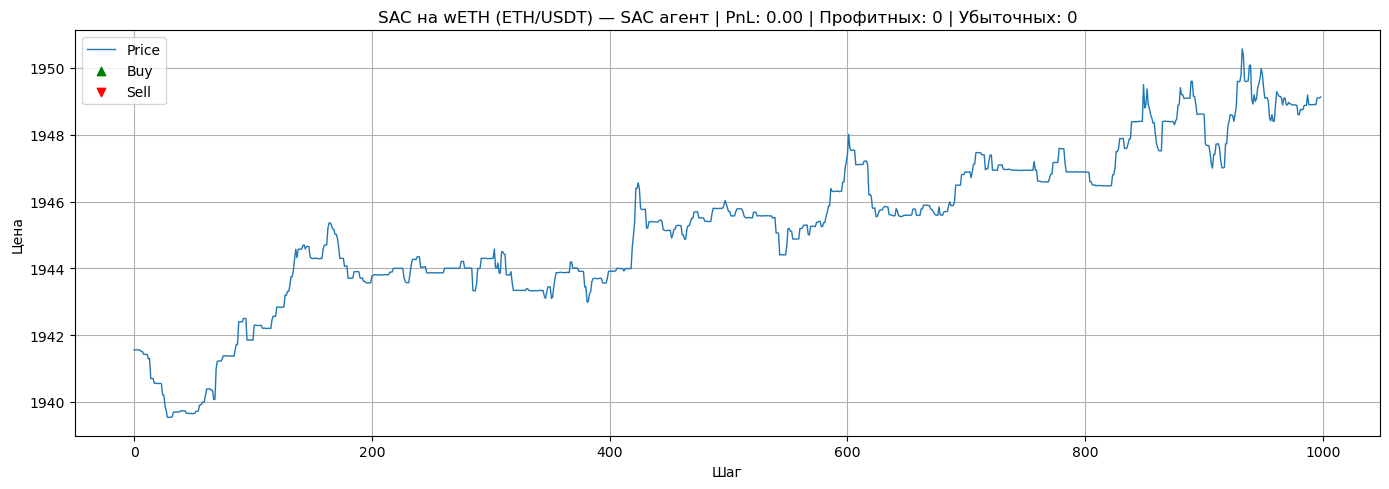

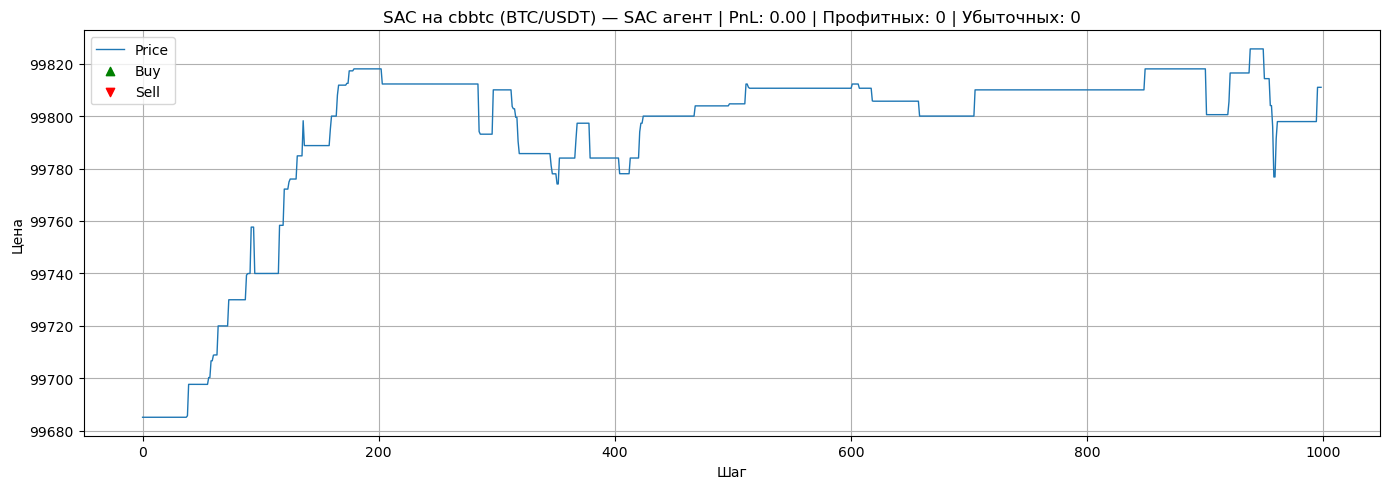

In [35]:
from stable_baselines3 import SAC

class MarketMakingEnvContinuous(gym.Env):
    def __init__(self, prices, latency=15):
        super().__init__()
        self.prices = prices
        self.latency = latency
        self.index = 0
        self.inventory = 0
        self.entry_price = None
        self.pending_action = None
        self.pending_time = None
        self.trades = []

        self.observation_space = spaces.Box(low=0, high=100000, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        self.inventory = 0
        self.entry_price = 0
        self.pending_action = None
        self.pending_time = None
        self.trades = []
        return np.array([self.prices[self.index], self.inventory], dtype=np.float32), {}

    def step(self, action):
        action = float(action)
        reward = 0

        if action < -0.2:
            decision = 1  # buy
        elif action > 0.2:
            decision = 2  # sell
        else:
            decision = 0  # hold

        if self.pending_action is not None and self.index >= self.pending_time:
            exec_price = self.prices[self.pending_time]
            if self.pending_action == 1 and self.inventory == 0:
                self.inventory = 1
                self.entry_price = exec_price
                self.trades.append(('buy', self.pending_time, exec_price))
            elif self.pending_action == 2 and self.inventory == 1:
                reward = exec_price - self.entry_price
                self.trades.append(('sell', self.pending_time, exec_price, reward))
                self.inventory = 0
                self.entry_price = 0
            self.pending_action = None
            self.pending_time = None

        if decision in [1, 2] and self.pending_action is None:
            self.pending_action = decision
            self.pending_time = self.index + self.latency

        self.index += 1
        done = self.index >= len(self.prices) - 1
        obs = np.array([self.prices[self.index], self.inventory], dtype=np.float32)
        return obs, reward, done, False, {}

def run_sac(prices, label):
    env = MarketMakingEnvContinuous(prices, latency=15)
    model = SAC("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=5000)

    obs, _ = env.reset()
    prices_log = []
    pnl = 0
    for _ in range(len(prices) - 1):
        action, _ = model.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        prices_log.append(obs[0])
        pnl += reward
        if done or truncated:
            break

    buy_idx = [t[1] for t in env.trades if t[0] == 'buy']
    sell_idx = [t[1] for t in env.trades if t[0] == 'sell']
    profit_trades = [t for t in env.trades if t[0] == 'sell' and t[3] > 0]
    loss_trades = [t for t in env.trades if t[0] == 'sell' and t[3] <= 0]
    profit_count = len(profit_trades)
    loss_count = len(loss_trades)
    profit_avg = np.mean([t[3] for t in profit_trades]) if profit_trades else 0
    loss_avg = np.mean([t[3] for t in loss_trades]) if loss_trades else 0

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 5))
    plt.plot(prices_log, label="Price", linewidth=1)
    plt.scatter(buy_idx, [prices_log[i] for i in buy_idx], color='green', marker='^', label='Buy')
    plt.scatter(sell_idx, [prices_log[i] for i in sell_idx], color='red', marker='v', label='Sell')
    plt.title(
        f"{label} — SAC агент | PnL: {pnl:.2f} | Профитных: {profit_count} | Убыточных: {loss_count}"
    )
    plt.xlabel("Шаг")
    plt.ylabel("Цена")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_sac(weth_prices, "SAC на wETH (ETH/USDT)")
run_sac(cbbtc_prices, "SAC на cbbtc (BTC/USDT)")

Из всех алгоритмов лучший вариант показал A2C. Проводим обучение и сохраняем модель для проведения эксперимента на реальных данных. 

In [37]:
class MarketMakingEnvLatency(gym.Env):
    def __init__(self, prices, latency=15):
        super().__init__()
        self.prices = prices
        self.latency = latency
        self.index = 0
        self.inventory = 0
        self.entry_price = None
        self.pending_action = None
        self.pending_time = None
        self.trades = []
        self.observation_space = spaces.Box(low=0, high=100000, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        self.index = 0
        self.inventory = 0
        self.entry_price = 0
        self.pending_action = None
        self.pending_time = None
        self.trades = []
        return np.array([self.prices[self.index], self.inventory], dtype=np.float32), {}

    def step(self, action):
        reward = 0
        price = self.prices[self.index]

        if self.pending_action is not None and self.index >= self.pending_time:
            exec_price = self.prices[self.pending_time]
            if self.pending_action == 1 and self.inventory == 0:
                self.inventory = 1
                self.entry_price = exec_price
                self.trades.append(('buy', self.pending_time, exec_price))
            elif self.pending_action == 2 and self.inventory == 1:
                reward = exec_price - self.entry_price
                self.inventory = 0
                self.entry_price = 0
                self.trades.append(('sell', self.pending_time, exec_price, reward))
            self.pending_action = None
            self.pending_time = None

        if action in [1, 2] and self.pending_action is None:
            self.pending_action = action
            self.pending_time = self.index + self.latency

        self.index += 1
        done = self.index >= len(self.prices) - 1
        obs = np.array([self.prices[self.index], self.inventory], dtype=np.float32)
        return obs, reward, done, False, {}

weth_df['datetime'] = pd.to_datetime(weth_df['timestamp'], unit='ms')
weth_df.set_index('datetime', inplace=True)
weth_prices = weth_df['price'].resample('1S').last().ffill().values[:1000]

env = MarketMakingEnvLatency(weth_prices, latency=15)
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

model.save("a2c_eth_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 161       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.05     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -3.06e-06 |
|    value_loss         | 7.99e-12  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 999       |
|    ep_rew_mean        | 7.97      |
| time/                 |           |
|    fps                | 166       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |       

In [43]:
symbol = 'ETH/USDT'
interval = 1  
lookback = 100
latency = 15
exchange = ccxt.binance()

model = A2C.load("a2c_eth_model.zip")

class RealTimeEnv:
    def __init__(self, latency=15):
        self.inventory = 0
        self.entry_price = None
        self.pending_action = None
        self.pending_time = None
        self.latency = latency
        self.prices = []
        self.index = 0
        self.trades = []
        self.pnl = 0

    def reset(self):
        self.inventory = 0
        self.entry_price = 0
        self.pending_action = None
        self.pending_time = None
        self.trades = []
        self.pnl = 0
        self.index = 0
        self.prices = []

    def step(self, price, action):
        reward = 0
        self.prices.append(price)
        self.index += 1

        if self.pending_action is not None and self.index >= self.pending_time:
            exec_price = self.prices[self.pending_time]
            if self.pending_action == 1 and self.inventory == 0:
                self.inventory = 1
                self.entry_price = exec_price
                self.trades.append(('buy', self.index, exec_price))
            elif self.pending_action == 2 and self.inventory == 1:
                reward = exec_price - self.entry_price
                self.pnl += reward
                self.inventory = 0
                self.entry_price = 0
                self.trades.append(('sell', self.index, exec_price, reward))
            self.pending_action = None
            self.pending_time = None

        if action in [1, 2] and self.pending_action is None:
            self.pending_action = action
            self.pending_time = self.index + self.latency

        return reward

    def get_obs(self):
        price = self.prices[-1]
        return np.array([price, self.inventory], dtype=np.float32)

env = RealTimeEnv(latency=latency)
env.reset()

print("Запуск A2C-агента для реального трейдинга (Binance)...")
try:
    while True:
        ticker = exchange.fetch_ticker(symbol)
        last_price = ticker['last']
        if len(env.prices) < lookback:
            env.prices.append(last_price)
            time.sleep(interval)
            continue

        obs = env.get_obs()
        action, _ = model.predict(obs)
        reward = env.step(last_price, action)

        print(f"Цена: {last_price:.2f} | Действие: {['Hold', 'Buy', 'Sell'][action]} | PnL: {env.pnl:.2f}")
        time.sleep(interval)

except KeyboardInterrupt:
    print("\nЗавершение. Финальная статистика:")
    profit_trades = [t for t in env.trades if t[0] == 'sell' and t[3] > 0]
    loss_trades = [t for t in env.trades if t[0] == 'sell' and t[3] <= 0]

    print(f"Профитных сделок: {len(profit_trades)} (ср. прибыль: {np.mean([t[3] for t in profit_trades]) if profit_trades else 0:.2f})")
    print(f"Убыточных сделок: {len(loss_trades)} (ср. убыток: {np.mean([t[3] for t in loss_trades]) if loss_trades else 0:.2f})")
    print(f"Общий PnL: {env.pnl:.2f}")


Запуск A2C-агента для реального трейдинга (Binance)...
Цена: 1986.61 | Действие: Buy | PnL: 0.00
Цена: 1986.60 | Действие: Buy | PnL: 0.00
Цена: 1986.53 | Действие: Buy | PnL: 0.00
Цена: 1986.92 | Действие: Buy | PnL: 0.00
Цена: 1986.92 | Действие: Buy | PnL: 0.00
Цена: 1986.81 | Действие: Buy | PnL: 0.00
Цена: 1985.20 | Действие: Buy | PnL: 0.00
Цена: 1985.67 | Действие: Buy | PnL: 0.00
Цена: 1985.59 | Действие: Buy | PnL: 0.00
Цена: 1985.49 | Действие: Buy | PnL: 0.00
Цена: 1985.51 | Действие: Buy | PnL: 0.00
Цена: 1985.30 | Действие: Buy | PnL: 0.00
Цена: 1985.13 | Действие: Buy | PnL: 0.00
Цена: 1985.50 | Действие: Buy | PnL: 0.00
Цена: 1985.40 | Действие: Buy | PnL: 0.00
Цена: 1985.18 | Действие: Buy | PnL: 0.00
Цена: 1985.10 | Действие: Buy | PnL: 0.00
Цена: 1984.42 | Действие: Buy | PnL: 0.00
Цена: 1984.59 | Действие: Buy | PnL: 0.00
Цена: 1983.88 | Действие: Buy | PnL: 0.00
Цена: 1983.32 | Действие: Buy | PnL: 0.00
Цена: 1983.53 | Действие: Buy | PnL: 0.00
Цена: 1983.62 | Дейст